In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate, GridSearchCV

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
# Load the data
df = pd.read_csv('music.csv')

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57879 entries, 0 to 57878
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        57879 non-null  int64  
 1   track_id          57879 non-null  object 
 2   artists           57879 non-null  object 
 3   album_name        57879 non-null  object 
 4   track_name        57879 non-null  object 
 5   popularity        57879 non-null  int64  
 6   duration_ms       57879 non-null  int64  
 7   explicit          57879 non-null  bool   
 8   danceability      57879 non-null  float64
 9   energy            57879 non-null  float64
 10  key               57879 non-null  int64  
 11  loudness          57879 non-null  float64
 12  mode              57879 non-null  int64  
 13  speechiness       57879 non-null  float64
 14  acousticness      57879 non-null  float64
 15  instrumentalness  57879 non-null  float64
 16  liveness          57879 non-null  float6

In [19]:
print(df.head)


<bound method NDFrame.head of        Unnamed: 0                track_id                 artists  \
0               0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1               1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2               2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3               3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4               4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   
...           ...                     ...                     ...   
57869       57869  1hP0hDL5VREpThmMOa1pta         Shakti Sivamani   
57870       57870  3fnvyhpihMGDGiO7l2EedI                Alien8ed   
57875       57875  034cAibJlvEZHcZcsyXraJ                   Foals   
57876       57876  6aWpHWeGhrBD6UEQY1TjNC                   Foals   
57877       57877  4sJgPt1yFyG7Ez2SQXzMWV                   Foals   

                                              album_name  \
0                                                 Comedy   
1                    

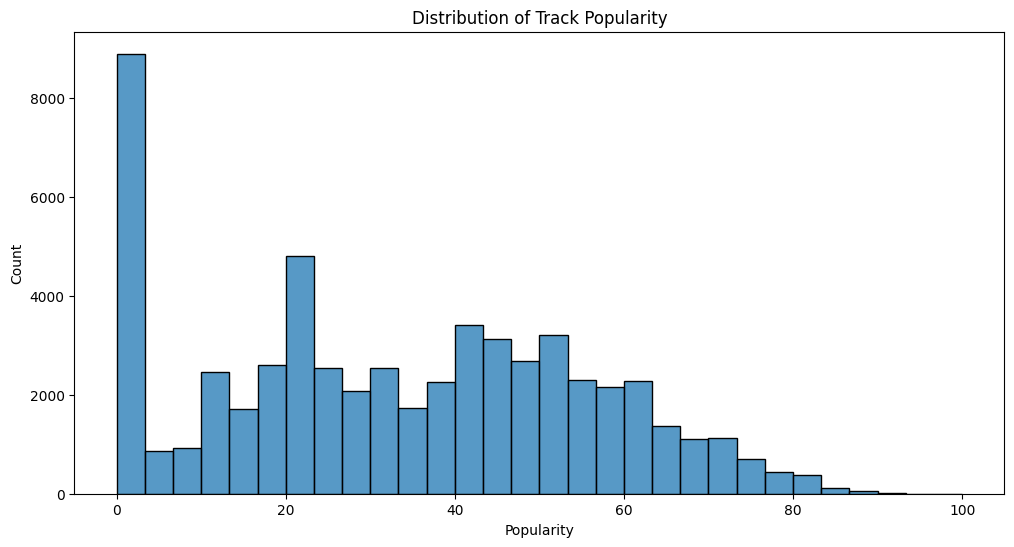

In [5]:
plt.figure(figsize=(12, 6))
sns.histplot(df['popularity'], bins=30)
plt.title('Distribution of Track Popularity')
plt.xlabel('Popularity')
plt.show()



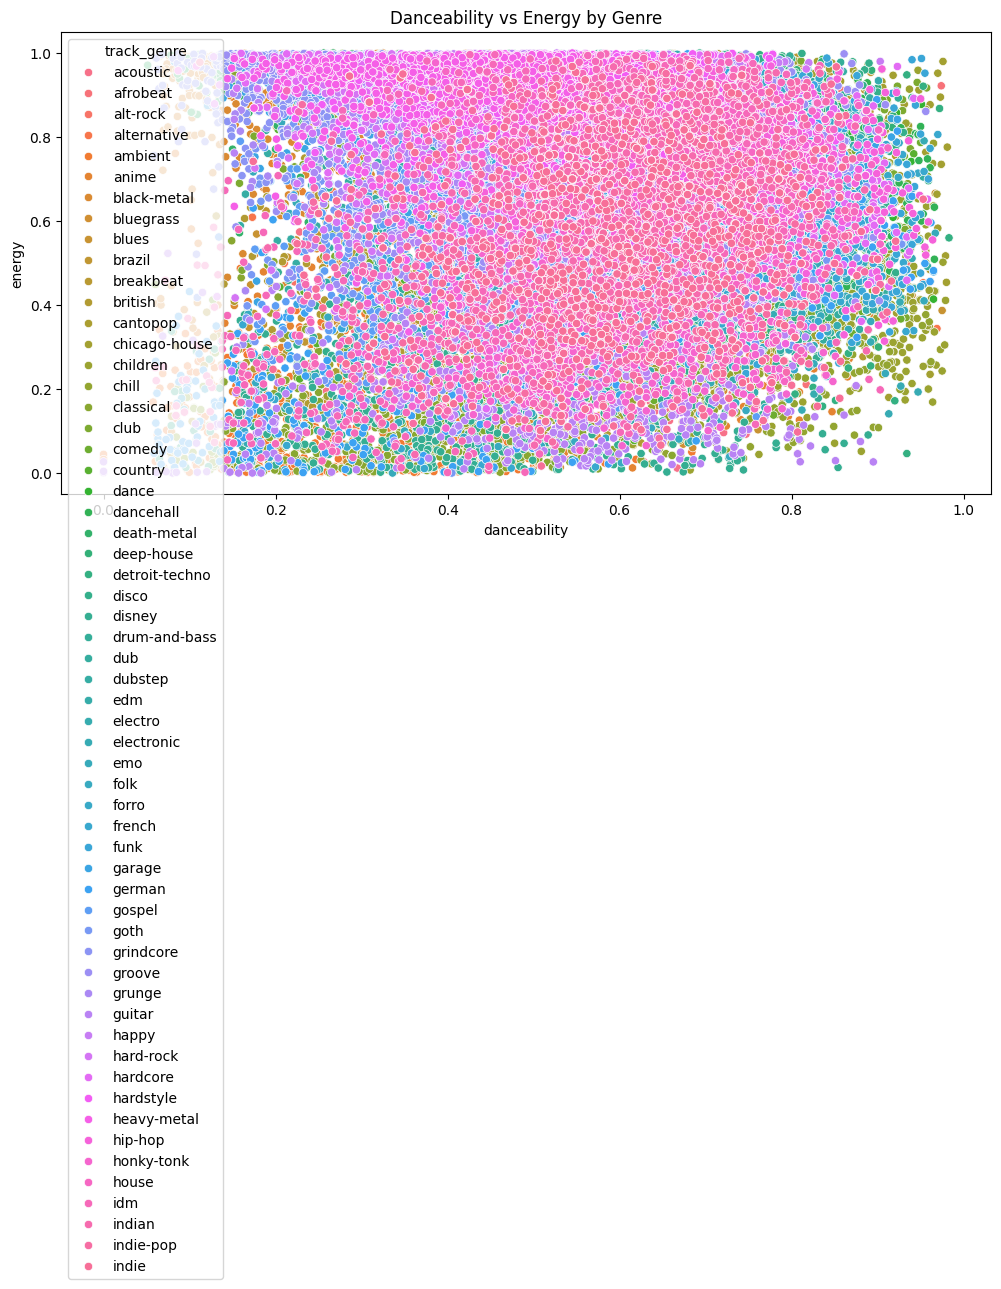

In [6]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='danceability', y='energy', hue='track_genre', data=df)
plt.title('Danceability vs Energy by Genre')
plt.show()

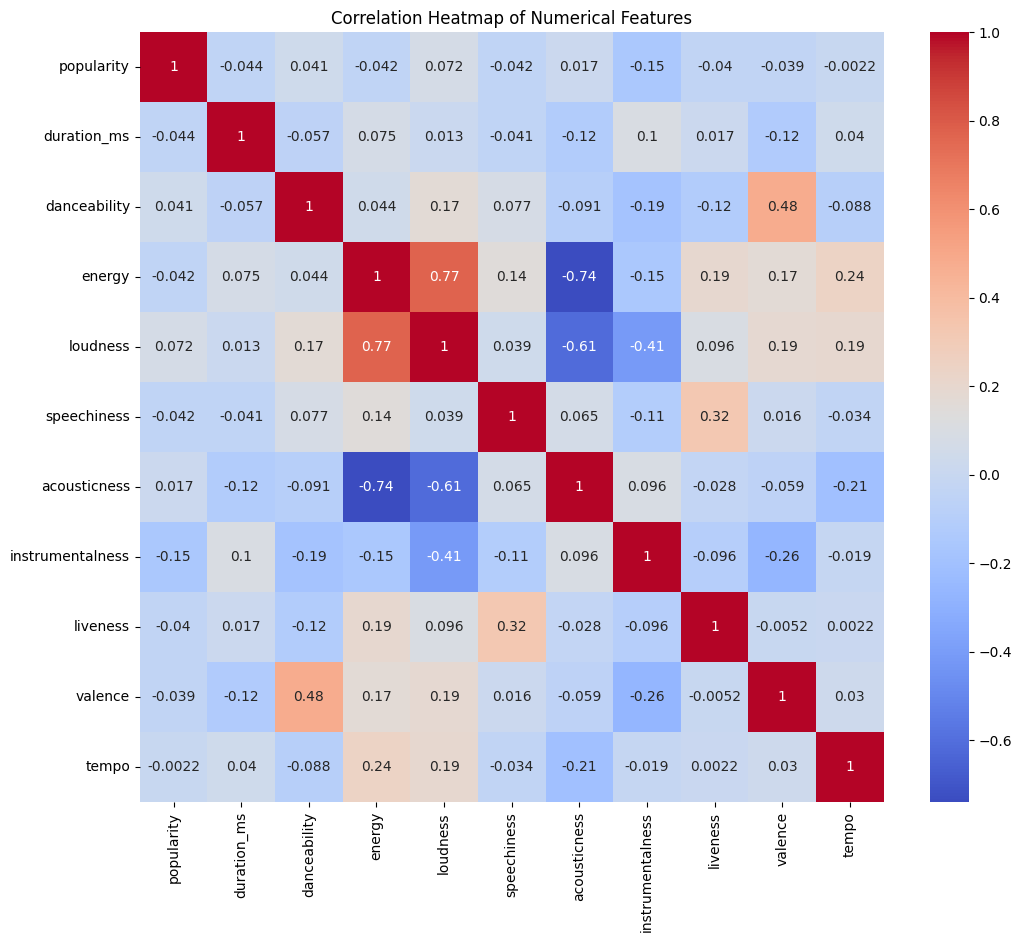

In [7]:
# Correlation heatmap of numerical features
numeric_features = ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
correlation_matrix = df[numeric_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [8]:
# Data Preprocessing
# Remove duplicates
df.drop_duplicates(subset=['track_id'], inplace=True)

# Handle missing values
df.dropna(inplace=True)

In [9]:
# Feature Engineering
# Create a new feature: popularity_category
df['popularity_category'] = pd.cut(df['popularity'], bins=[0, 25, 50, 75, 100], labels=['Low', 'Medium', 'High', 'Very High'])


In [10]:
# Normalize numerical features
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])


In [11]:
# Prepare data for collaborative filtering
# We'll use the 'popularity' as a proxy for user ratings
user_item_matrix = df.pivot(index='artists', columns='track_id', values='popularity').fillna(0)


In [12]:
# Singular Value Decomposition (SVD) for matrix factorization
U, sigma, Vt = svds(user_item_matrix.values, k=50)


In [13]:
# Reconstruct the matrix
sigma = np.diag(sigma)
predicted_ratings = np.dot(np.dot(U, sigma), Vt)


In [14]:
# Create a DataFrame with the predicted ratings
preds_df = pd.DataFrame(predicted_ratings, columns=user_item_matrix.columns, index=user_item_matrix.index)


In [15]:
# Function to get top N recommendations for a user
def get_recommendations(user, N=10):
    user_ratings = preds_df.loc[user].sort_values(ascending=False)
    recommended_items = user_ratings.head(N)
    return df[df['track_id'].isin(recommended_items.index)][['track_id', 'track_name', 'artists', 'album_name']]


In [16]:
# Example usage
print(get_recommendations('Gen Hoshino', N=5))

                     track_id                   track_name    artists  \
14001  6YQ7aPJhk0MGpwoKfFAEbS            Wheels on the Bus  CoComelon   
14005  0dF7HP4wDwxCtID3mXpdYX          Baa Baa Black Sheep  CoComelon   
14012  097ftnCPnGHhn93lS0HHlO  Twinkle Twinkle Little Star  CoComelon   
14013  6cKlr2BOXBaqiuaHUY5Zwo            Itsy Bitsy Spider  CoComelon   
14016  3NEgsdTwk3tIjt6x4d2VzE              Rock-a-Bye Baby  CoComelon   

                        album_name  
14001  CoComelon Kids Hits, Vol. 1  
14005  CoComelon Kids Hits, Vol. 1  
14012  CoComelon Kids Hits, Vol. 3  
14013  CoComelon Kids Hits, Vol. 1  
14016  CoComelon Kids Hits, Vol. 2  


In [17]:
# Model Evaluation using Surprise library
reader = Reader(rating_scale=(0, 100))
data = Dataset.load_from_df(df[['artists', 'track_id', 'popularity']], reader)


In [18]:
# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


TypeError: Singleton array array(<surprise.dataset.DatasetAutoFolds object at 0x00000297821B10D0>,
      dtype=object) cannot be considered a valid collection.

In [ ]:
# Train and evaluate the SVD model
svd_model = SVD(n_factors=50, random_state=42)
cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Hyperparameter Tuning
param_grid = {
    'n_factors': [30, 50, 100],
    'n_epochs': [20, 30, 50],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.1]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

print(gs.best_score['rmse'])


In [ ]:
print(gs.best_params['rmse'])

In [ ]:
# Train the final model with best parameters
best_svd = gs.best_estimator['rmse']
best_svd.fit(trainset)

In [ ]:
# Make predictions on the test set
test_predictions = best_svd.test(testset)

In [ ]:
# Calculate RMSE
test_rmse = mean_squared_error(
    [pred.r_ui for pred in test_predictions],
    [pred.est for pred in test_predictions],
    squared=False
)
print(f"Test RMSE: {test_rmse}")


In [ ]:
#Create a function for getting personalized recommendations
def get_personalized_recommendations(user_id, N=10):
    user_ratings = df[df['artists'] == user_id]
    unrated_tracks = df[~df['track_id'].isin(user_ratings['track_id'])]
    
    predictions = []
    for _, track in unrated_tracks.iterrows():
        pred = best_svd.predict(user_id, track['track_id'])
        predictions.append((track['track_id'], pred.est))
    
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_n = predictions[:N]
    
    recommended_tracks = df[df['track_id'].isin([i[0] for i in top_n])][['track_id', 'track_name', 'artists', 'album_name']]
    return recommended_tracks

In [ ]:
# Example usage of personalized recommendations
print(get_personalized_recommendations('Gen Hoshino', N=5))